# Graph exploration & analysis

--------------

## Preliminaries

- ### Objective :

Predict the virality of memes/hashtags in a social network (Twitter).

- ### Context and motivations :

Virality is, in social networks, an important issue for corporations, political campaigns and influencers as they spend enormous resources and efforts to make their products or messages go viral in order to catch attention and spread their influence/activities to a wider audience.
Thus, understanding the complex mechanism of virality may help one control its effects over the network:
- How does the network structure affect the diffusion? 
- How to model the contagion, etc.

Proposal brought by the paper : the  broad idea is that network communities allow predict virality by its early spreading pattern. A simple, popular approach in studying hashtags diffusion is to consider hashtags as diseases and apply epidemic models. However, recent studies demonstrate that diseases and behaviors spread differently.
We can see huge potentiality for applications in social media marketing : social networks could give better advice to their users as to which posts are likely to give best advertising Return on Investment.


- ### Imports

In [27]:
import pandas as pd
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from itertools import product
from itertools import permutations
%matplotlib inline

## I. Data exploration

**** CITATION ****
Please cite our paper as follows, when you are using our dataset:
Lilian Weng, Filippo Menczer, and Yong-Yeol Ahn. Virality Prediction and Community Structure in Social Networks. Nature Scientific Report. (3)2522, 2013.



**** DATA SOURCE ****
Sampled public tweets from Twitter streaming API (https://dev.twitter.com/docs/streaming-apis).
Date range: March 24, 2012 to April 25, 2012.



**** NETWORKS ****
follower_gcc.anony.dat:
    Format: anony.user1.ID anony.user2.ID
    Anonymized reciprocal follower network.
    Each edge is a pair of Twitter user who are following each other. After recovering the reciprocal follower network, the giant connected component is extracted.

retweet_gcc.anony.dat:
    Format: anony.user1.ID anony.user2.ID weight
    Anonymized reciprocal retweet network.
    Similarly to follower_gcc.anony.dat, but instead each edge is a pair of users who retweeted each other at least once during our observation time window. Weight is the sum of how many times user1 retweeted user2 or user2 retweeted user1.

mention_gcc.anony.dat:
    Format: anony.user1.ID anony.user2.ID weight
    Anonymized reciprocal retweet network.
    Similarly to follower_gcc.anony.dat, but instead each edge is a pair of users who mentioned each other at least once during our observation time window. Weight is the sum of how many times user1 mentioned user2 or user2 mentioned user1.



**** HASHTAG SEQUENCES ****
timeline_tag.anony.dat
    Format: hashtag timestamp1,anony.user1.id timestamp2,anony.user2.id ...
    Each line is a hashtag followed by the sequence of its adopters sorted by timestamp. A user is considered as an adopter of a hashtag once he/she starts using the hashtag. We only consider users who appear in the collected networks. The timestamp is the time when we see the hashtag in the user's tweets. The file includes both emergent hashtags and non-emergent ones.

timeline_tag_rt.anony.dat
    Format: hashtag timestamp1,anony.retweet_user1.id,anony.retweet_from_user1.id timestamp2,anony.retweet_user2.id,anony.tweet_from_user2.id ...
    Each line is a hashtag followed by the sequence of its adopters retweeting about this hashtag from other users sorted by timestamp. A "retweet_user" retweets a message containing the hashtag from a "retweet_from_user". We only consider users who appear in the collected networks. The file includes both emergent hashtags and non-emergent ones.

timeline_tag_men.anony.dat
    Format: hashtag timestamp1,anony.mention_user1.id,anony.mentioned_user1.id timestamp2,anony.mention_user2.id,anony.mentioned_user2.id ...
    Each line is a hashtag followed by the sequence of its adopters mentioning other users in messages containing this hashtags sorted by timestamp. A "mention_user" mentions a "mentioned_user" in a message with the target hashtag. We only consider users who appear in the collected networks. The file includes both emergent hashtags and non-emergent ones.



** Note that users in these networks and timeline sequencies are anonymized in the same way so that the same IDs refer to the same Twitter users.

In [28]:
#load from raw dat file into dataframes
    #for relationships graphs
df1 = pd.read_csv('../../../virality2013/follower_gcc.anony.dat',sep=' ',header=None,names=["user_1","user_2"])
#df2 = pd.read_csv('../../../virality2013/mention_gcc.anony.dat',sep=' ',header=None,names=["user_1","user_2","weight"])
#df3 = pd.read_csv('../../../virality2013/retweet_gcc.anony.dat',sep=' ',header=None,names=["user_1","user_2","weight"])
    
    #for hashtags spreading, the data format is too large to compute as matrix (over billion units)
#df4 = pd.read_csv('../../../virality2013/timeline_tag.anony.dat',sep=' ',header=None,names=header_tl)
#df5 = pd.read_csv('../../../virality2013/timeline_tag_men.anony.dat',sep=' ',header=None,names=header_tl_men)
#df6 = pd.read_csv('../../../virality2013/timeline_tag_rt.anony.dat',sep=' ',header=None,names=header_tl_rt)

- ### Hashtags analysis

In [29]:
ht=[]
l=[]
n=0
with open('../../../virality2013/timeline_tag.anony.dat',"r") as f:
    for line in f:
        hashtag = line.split(" ")[0]
        size = len(line.split(" "))
        ht.append(hashtag)
        l.append(size)
ht_df=pd.DataFrame()
ht_df['hashtag']=ht
ht_df['count_adopters']=l

print("Max len for a row : %s" %max(l))
print("Nb of hashtags : %s" %(len(ht)))

Max len for a row : 363519
Nb of hashtags : 1345913


In [30]:
ht_df = ht_df[ht_df['hashtag'].str.len() > 3] #filter meaningless hashtags
ht_df.sort(columns='count_adopters',ascending=False,inplace=True)
ht_df.reset_index(inplace=True,drop=True)

/home/paul/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app


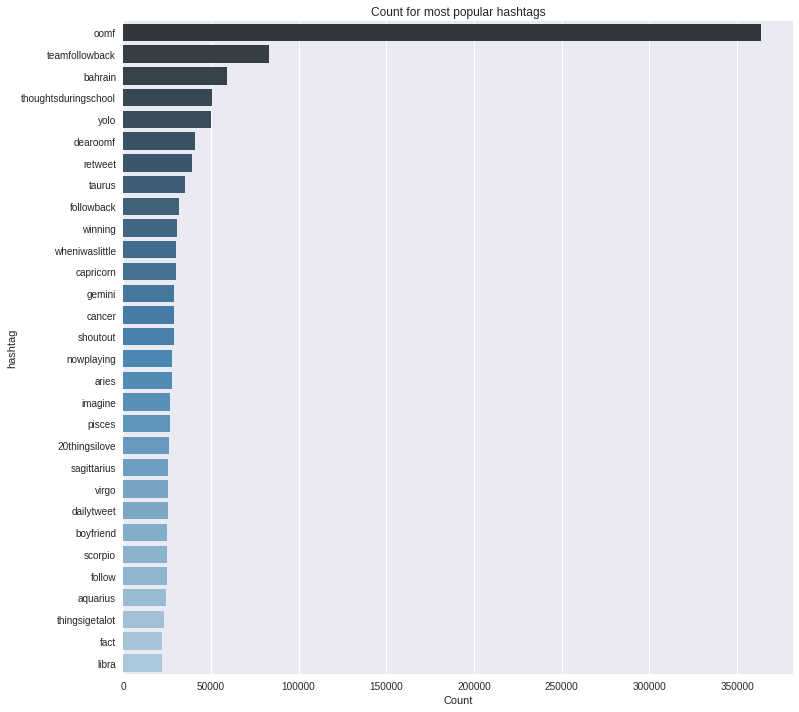

In [31]:
ht_df_ = ht_df[0:30]
plt.figure(figsize=(12,12))
a=sns.barplot(y=ht_df_['hashtag'],x=ht_df_['count_adopters'],palette="Blues_d")
a.set_title('Count for most popular hashtags')
a.set_xlabel('Count')

- ### Light Network Analysis:

In [32]:
%%time
g1 = nx.from_pandas_dataframe(df1,source="user_1",target="user_2") #.to_undirected()
del df1 #supress to free memory
g1 = g1.to_undirected()

CPU times: user 2min 57s, sys: 3.41 s, total: 3min
Wall time: 2min 59s


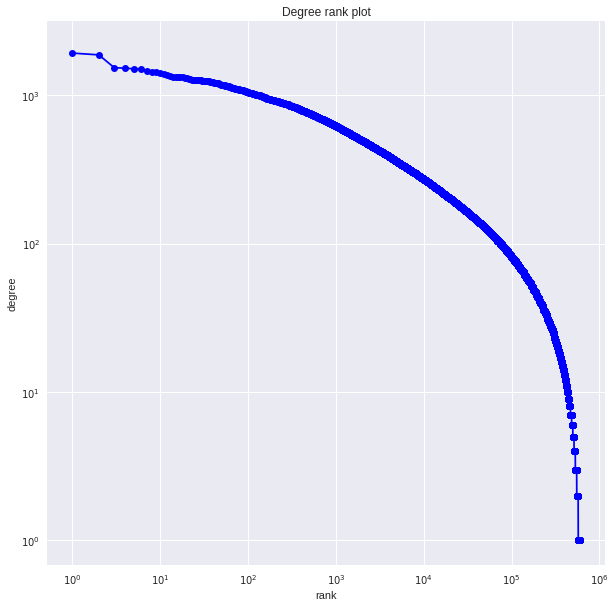

CPU times: user 13.7 s, sys: 36 ms, total: 13.8 s
Wall time: 13.7 s


In [33]:
%%time
degree_sequence=sorted(nx.degree(g1).values(),reverse=True) # degree sequence
#print "Degree sequence", degree_sequence
dmax=max(degree_sequence)

plt.figure(figsize=(10,10))
plt.loglog(degree_sequence,'b-',marker='o')
plt.title("Degree rank plot")
plt.ylabel("degree")
plt.xlabel("rank")

plt.show()

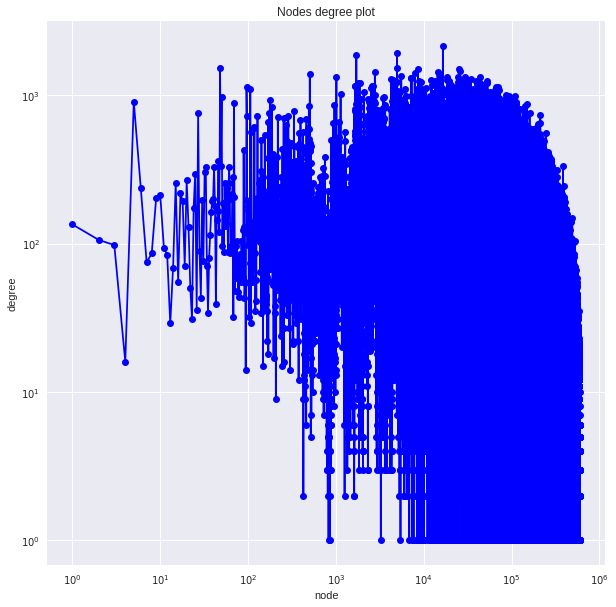

CPU times: user 6.92 s, sys: 32 ms, total: 6.95 s
Wall time: 6.93 s


In [34]:
%%time
degree_sequence=nx.degree(g1).values()
#print "Degree sequence", degree_sequence
dmax=max(degree_sequence)

plt.figure(figsize=(10,10))
plt.loglog(degree_sequence,'b-',marker='o')
plt.title("Nodes degree plot")
plt.ylabel("degree")
plt.xlabel("node")

plt.show()

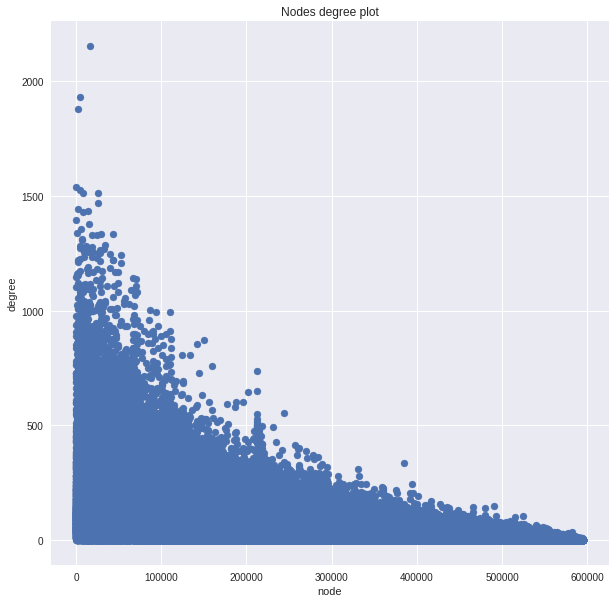

CPU times: user 21.7 s, sys: 64 ms, total: 21.7 s
Wall time: 21.7 s


In [35]:
%%time
degree_sequence=nx.degree(g1).values()
#print "Degree sequence", degree_sequence
dmax=max(degree_sequence)

plt.figure(figsize=(10,10))
plt.scatter(nx.degree(g1).keys(),degree_sequence)
plt.title("Nodes degree plot")
plt.ylabel("degree")
plt.xlabel("node")

plt.show()

(array([  5.78368000e+05,   1.40960000e+04,   2.10800000e+03,
          5.96000000e+02,   2.01000000e+02,   7.00000000e+01,
          1.40000000e+01,   4.00000000e+00,   2.00000000e+00,
          1.00000000e+00]),
 array([  1.00000000e+00,   2.16100000e+02,   4.31200000e+02,
          6.46300000e+02,   8.61400000e+02,   1.07650000e+03,
          1.29160000e+03,   1.50670000e+03,   1.72180000e+03,
          1.93690000e+03,   2.15200000e+03]),
 <a list of 10 Patch objects>)

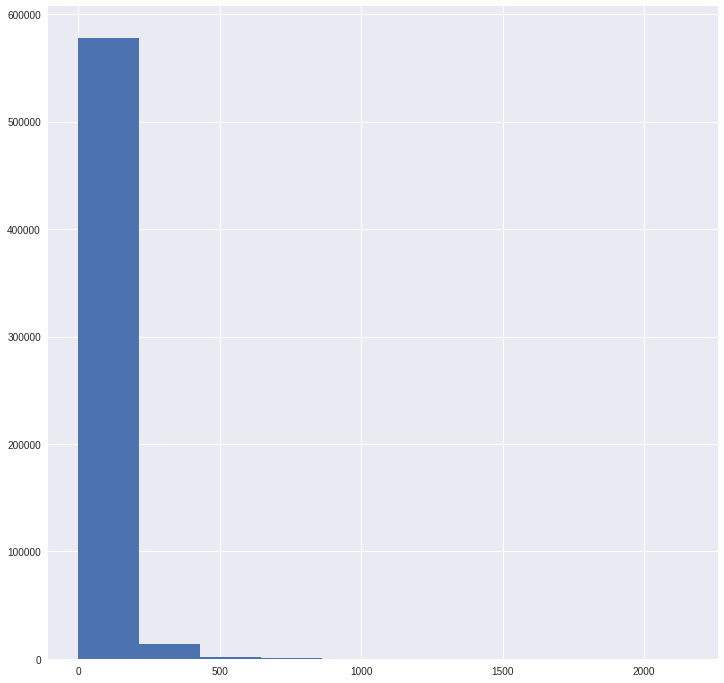

In [36]:
plt.figure(figsize=(12,12))
plt.hist(degree_sequence)

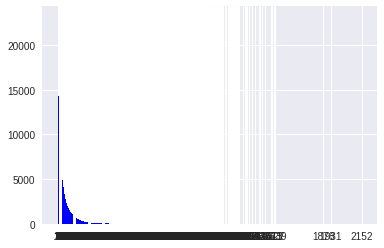

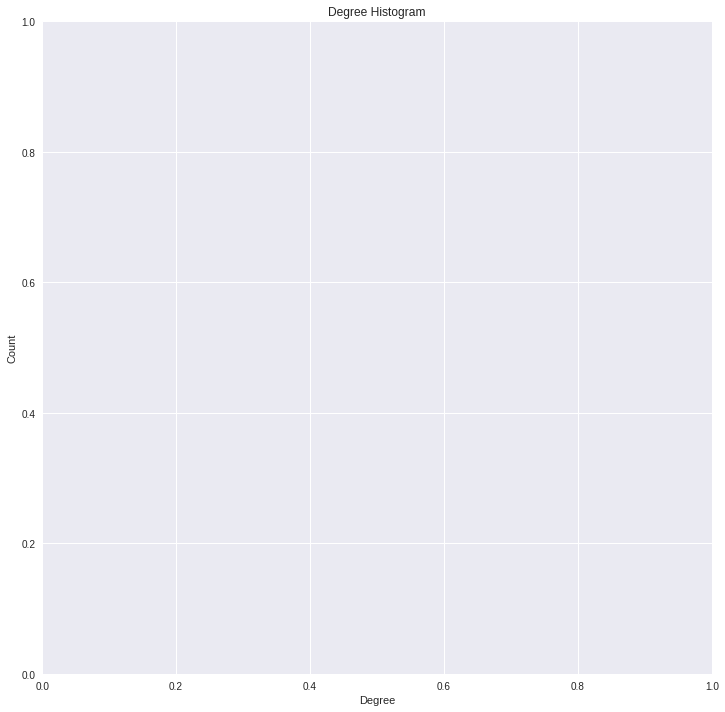

In [37]:
#Degrees histograms
import collections



degree_sequence=sorted(g1.degree().values(), reverse=True) # degree sequence
#print "Degree sequence", degree_sequence
degreeCount=collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())

fig, ax = plt.subplots()
plt.bar(deg, cnt, width=0.80, color='b')
plt.figure(figsize=(12,12))
plt.title("Degree Histogram")
plt.ylabel("Count")
plt.xlabel("Degree")
ax.set_xticks([d+0.4 for d in deg])
ax.set_xticklabels(deg)

plt.show()

In [38]:
#degree distribution

## II. Sampling

- ### Random node sampling: 

In [39]:
def sample_nodes(node_list,ratio):
    nb_sample = ratio*len(node_list)
    nb_sample = int(nb_sample)
    sample = np.random.choice(np.array(node_list),size=nb_sample)
    return sample

def get_nodes(g):
    node_list = list(g.nodes())
    return node_list

def induced_graphed(vertex,g):
    return 

In [40]:
%%time
nodes1 = get_nodes(g1)
sample = sample_nodes(nodes1,0.01)

CPU times: user 48 ms, sys: 0 ns, total: 48 ms
Wall time: 48.1 ms


- ### Degree distribution sampling

## III. Hashtags community:

In [41]:
def extract_from_hash(hashtag,file_path,extended=True):
    mat = []    
    if extended == True:
        with open(file_path,"r") as f:
            for line in f:
                if hashtag in line:
                    mat.append(line.split(" "))
        pading =    max([len(x) for x in mat])      
        mat = np.array([np.array(pad(x,pading)) for x in mat])
        return pd.DataFrame(mat)
    else:
        with open(file_path,"r") as f:
            for line in f:
                if hashtag == line.split(" ")[0]:
                    mat.append(line.split(" "))
                    break
        pading =    max([len(x) for x in mat])      
        mat = np.array([np.array(pad(x,pading)) for x in mat])
        return pd.DataFrame(mat)

def pad(list_,length):
    return list_[:length] + [np.nan]*(length-len(list_))

def find_infected_vertex(df):
    keep=[]
    for col in df.columns[1:]:
        array=split_clean(df[col])
        keep.append([x[1] for x in array if isinstance(x,list)])
    return list(set([val for sublist in keep for val in sublist]))

def split_clean(list_):
    array= [ x.split(",") for x in list_]
    array= [ np.nan if x[0]=='nan' else [int(x[0]),int(x[1].strip('\n'))] for x in array ]
    return array

def query_from_vertices(df,liste_):
    df=df[(df['user_1'].isin(liste_)) | (df["user_2"].isin(liste_))]
    return df

In [42]:
%%time
df = extract_from_hash('yolo',"../../../virality2013/timeline_tag.anony.dat",extended = True)

CPU times: user 21.7 s, sys: 836 ms, total: 22.5 s
Wall time: 22.5 s


In [55]:
ht_df[ht_df["count_adopters"]>=2000]

,hashtag,count_adopters
0,oomf,363519
1,teamfollowback,83065
2,bahrain,59278
3,thoughtsduringschool,50928
4,yolo,50257
5,dearoomf,40895
6,retweet,39098
7,taurus,35310
8,followback,31758
9,winning,30934


In [56]:
%%time
#guncontrol teamunicorns
df = extract_from_hash('springbreak',"../../../virality2013/timeline_tag.anony.dat",extended = False)
t=find_infected_vertex(df)


CPU times: user 924 ms, sys: 20 ms, total: 944 ms
Wall time: 941 ms


In [ ]:
%%time
#combination

#50 minutes to compute
nodes_=[]
for i,j in permutations(t,2):
    try:
        nodes_.append(nx.shortest_path(g1,source=i,target=j))
    except Exception as e:
        print('Failed at stage %s %s for reason : %s' %(i,j,e))

In [58]:
%%time
flat=[]
for element in nodes_:
    try:
        flat.append([x for x in element])
    except Exception as e:
        print(e)

CPU times: user 10.8 s, sys: 24 ms, total: 10.8 s
Wall time: 10.8 s


In [59]:
def to_flat(liste_):
    flat=[]
    for element in liste_:
        try:
            flat.append([x for x in element])
        except Exception as e:
            print(e)
    return flat

In [60]:
flat[0:100]

[[423255, 423256, 467752, 250003, 289094, 431059, 557068],
 [423255, 423256, 215841, 191712, 33565, 344077],
 [423255, 47022, 128366, 178042, 205994, 286747],
 [423255, 95011, 47019, 421807, 204832, 204828],
 [423255, 423256, 215841, 191712, 43719, 196638],
 [423255, 375824, 65378, 365415, 49183],
 [423255, 375824, 381680, 142212, 301688, 387491, 450597],
 [423255, 423256, 35291, 10000, 197861, 237611],
 [423255, 423256, 35291, 34007, 170926, 106542],
 [423255, 423256, 215841, 39232, 93304, 41009],
 [423255, 423256, 440698, 377625, 127475, 106546],
 [423255, 95011, 45573, 331267, 127947, 383667],
 [423255, 375824, 65378, 7883, 65589],
 [423255, 47022, 128366, 20480, 20489],
 [423255, 423256, 215841, 4947, 140245, 524345],
 [423255, 406763, 28412, 6574, 90176],
 [423255, 406763, 28412, 64671, 274058, 344131],
 [423255, 423256, 440698, 377625, 127475, 106564],
 [423255, 95011, 47027, 339268, 360542, 360518],
 [423255, 47033, 5877, 325665, 245833],
 [423255, 375824, 65378, 332, 63708, 478

In [61]:
%%time
#nodes_=np.array(flat).flatten()
flat_=[val for sublist in flat for val in sublist]
#flat_=[val for sublist in flat_ for val in sublist]

CPU times: user 1.39 s, sys: 0 ns, total: 1.39 s
Wall time: 1.39 s


In [62]:
h=g1.subgraph(flat_)
len(h.edges())

4355328

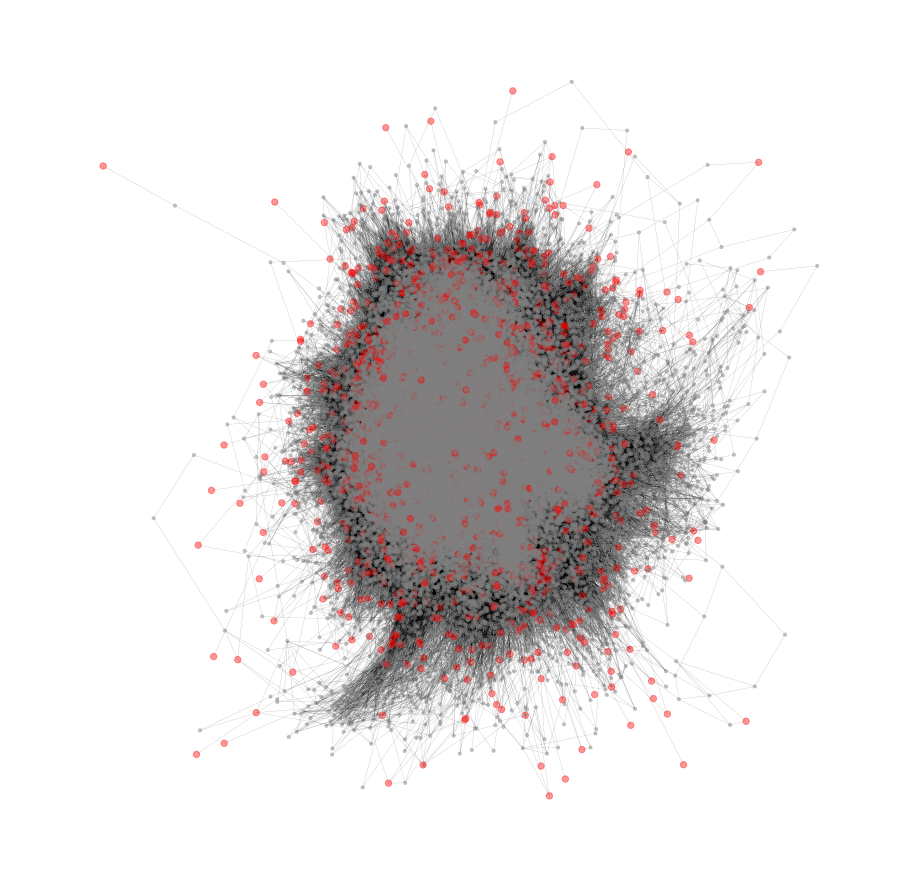

CPU times: user 10h 39min 7s, sys: 0 ns, total: 10h 39min 7s
Wall time: 10h 39min 25s


In [63]:
%%time

color_map=[]
size = []
for node in h:
    if node in t:
        color_map.append('red')
        size.append(40)
    else:
        color_map.append('grey')
        size.append(10)
        
options_3 = {
 'with_labels': False,
 'node_color': color_map,
 'node_size': size,
 'linewidths': 1,
 'width': 0.2,
 'alpha': 0.4
}



plt.figure(figsize=(12,12))

nx.draw_spring(h, **options_3)
plt.savefig("graph4_genocide.png", dpi=400)
plt.show()

In [64]:
del g1
del h